In [13]:
import torch
import matplotlib.pyplot as plt
import kornia as K
import torchfields
from tqdm import tqdm
import torchvision.transforms.functional as F1
from torchvision.transforms import v2
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as Fun
from utils import viewer_3d,show_mv,plt_images,complex_pyramid,complex_NLL,complex_total_variation
from data_loader import slicing
from complexPyTorch.complexFunctions import complex_upsample, complex_upsample2

In [472]:
f_pos = torch.load('/Users/pi58/Library/CloudStorage/Box-Box/PhD/Low Field Data-1/20230213 - Chloe for Itamar/TSEV3_1_highGrad/1/k_space.t')
f_inv = torch.load("/Users/pi58/Library/CloudStorage/Box-Box/PhD/Low Field Data-1/20230213 - Chloe for Itamar/TSEV3_1_highGrad_invPol/1/k_space.t")


img_pos = torch.fft.ifftshift(torch.fft.ifftn(f_pos))  # Image space
f_inv = torch.flip(f_inv,[0])
f_inv = torch.flip(f_inv,[1,2])
img_inv = torch.fft.ifftshift(torch.fft.ifftn(f_inv))
# img_inv = torch.flip(img_inv,[1,2])
# f_pos, f_inv, img_pos, img_inv = slicing(img_pos, img_inv)

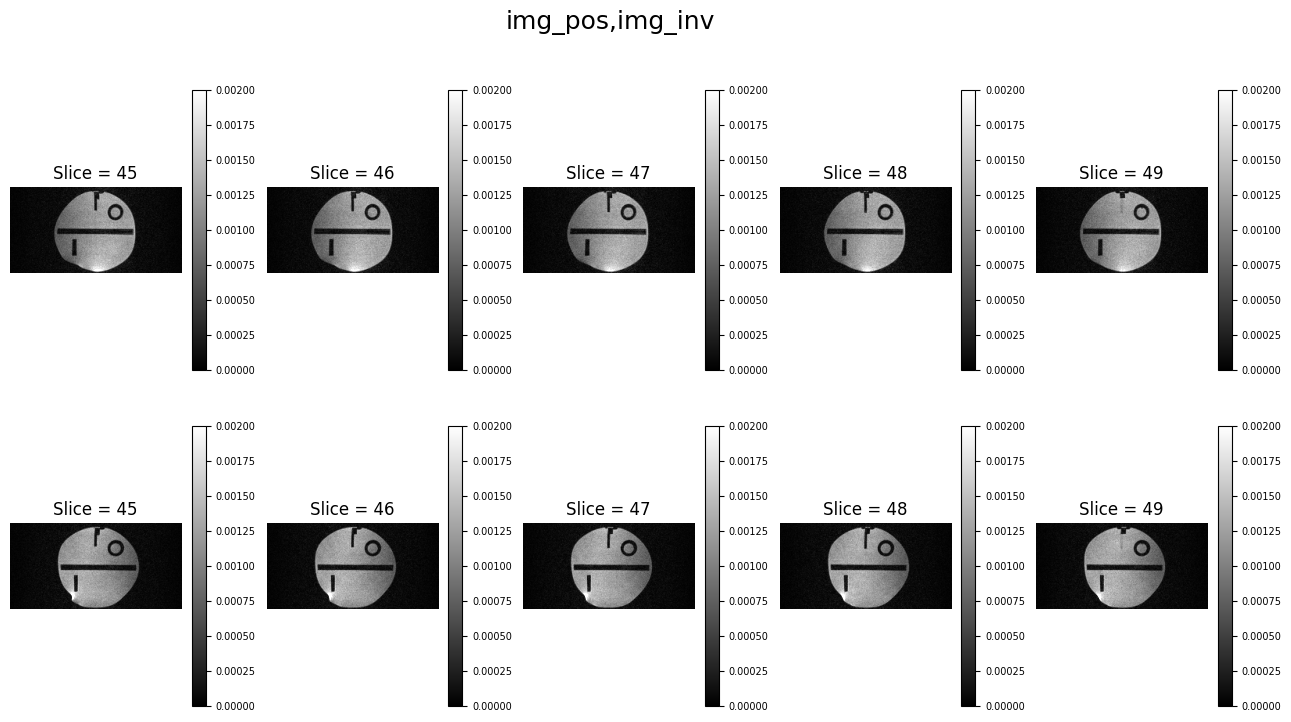

In [480]:
slices = [45,46,47,48,49]
z = [img_pos.abs(),img_inv.abs()]
plt_images(slices,z,"img_pos,img_inv",0,0.002)

Smoothening kspace data 

In [392]:
def get_gaussian_kernel1d(kernel_size, sigma):
    ksize_half = (kernel_size - 1) * 0.5

    x = torch.linspace(-ksize_half, ksize_half, steps=kernel_size)
    pdf = torch.exp(-0.5 * (x / sigma).pow(2))
    # print(torch.sum(pdf))
    kernel1d = pdf / pdf.sum()
    return kernel1d


def get_gaussian_kernel2d(kernel_size, sigma, device='cpu'):
    kernel1d_x = get_gaussian_kernel1d(kernel_size[0], sigma[0]).to(device)
    kernel1d_y = get_gaussian_kernel1d(kernel_size[1], sigma[1]).to(device)
    
    kernel2d = torch.mm(kernel1d_y[:, None], kernel1d_x[None, :])
    
    return kernel2d

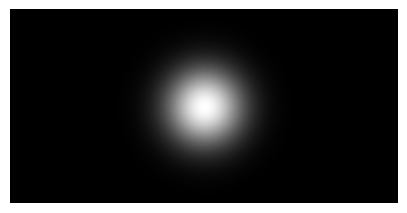

In [437]:
M,N = f_pos[0].shape
H = np.zeros((M,N), dtype=np.float32)
D0 = 15.0
for u in range(M):
    for v in range(N):
        D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
        H[u,v] = np.exp(-D**2/(2*D0*D0))
plt.figure(figsize=(5,5))
plt.imshow(H, cmap='gray')
plt.axis('off')
plt.show()


(110, 220)

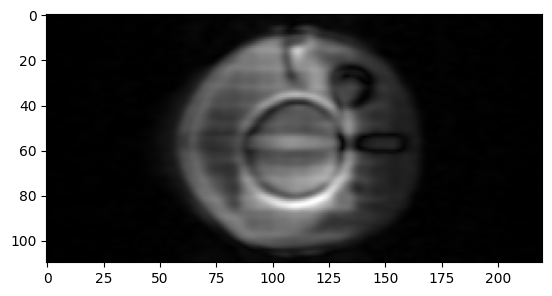

In [438]:
Gshift = f_pos[45,] * H

G = np.abs(np.fft.ifft2(Gshift))
G = np.fft.ifftshift(G)
plt.imshow(G,cmap='gray')
plt.show()

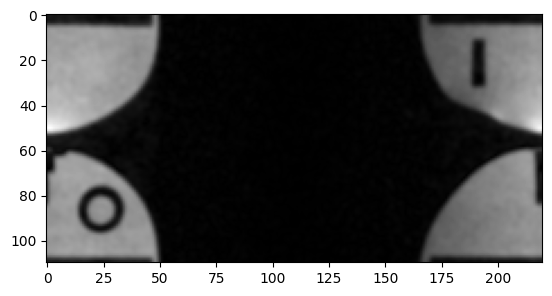

In [424]:

smoothened = []
gaussian_kernel = get_gaussian_kernel2d((220,110),(1.1,1.1))
gaussian_kernel = np.fft.fftshift(np.fft.fftn(gaussian_kernel))


for i in range(len(f_pos)):
    temp = f_pos[i] * gaussian_kernel
    temp = temp.reshape(1,110,220)
    smoothened.append(temp)


smoothened = torch.cat(smoothened,dim=0)
z1 = torch.fft.ifftshift(torch.fft.ifftn(smoothened)).abs()
plt.imshow(z1[45,],cmap='gray')

In [335]:
smoothened.sum()

tensor(-21.1367-13.8467j, dtype=torch.complex128)

In [282]:
a = torch.randn(110,220).reshape(1,110,220)
b = torch.randn(110,220).reshape(1,110,220)
print(torch.cat((a,b),dim=0).shape)

torch.Size([2, 110, 220])


In [258]:
f_pos[0].shape

torch.Size([110, 220])

Plotting Magnitude and Phase polots of img_pos and img_inv

torch.Size([100, 110, 220])


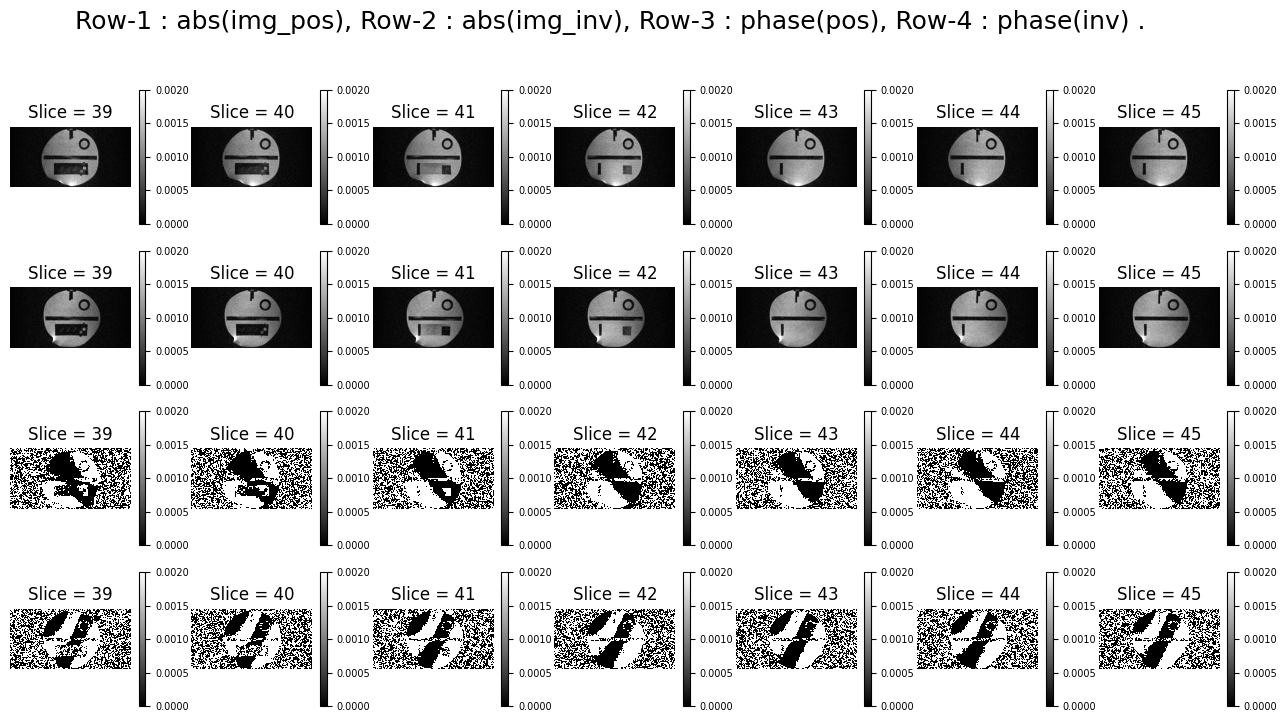

In [246]:
slices = [39,40,41,42,43,44,45]
z1 = img_pos.reshape(100,img_pos.shape[-2],img_pos.shape[-1])
z2 = img_inv.reshape(100,img_inv.shape[-2],img_inv.shape[-1])
print(z1.shape)
phase1 = (torch.atan2(torch.imag(z1),torch.real(z1)))
phase2 = (torch.atan2(torch.imag(z2),torch.real(z2)))
z = [z1.abs(),z2.abs(),phase1,phase2]
plt_images(slices,z,"Row-1 : abs(img_pos), Row-2 : abs(img_inv), Row-3 : phase(pos), Row-4 : phase(inv) .",0, 0.002)

Center Crop of kspace data

In [ ]:
f_pos = torch.load('/Users/pi58/Library/CloudStorage/Box-Box/PhD/Low Field Data-1/20230213 - Chloe for Itamar/TSEV3_1_highGrad/1/k_space.t')
f_inv = torch.load("/Users/pi58/Library/CloudStorage/Box-Box/PhD/Low Field Data-1/20230213 - Chloe for Itamar/TSEV3_1_highGrad_invPol/1/k_space.t")


img_pos = torch.fft.ifftshift(torch.fft.ifftn(f_pos))  # Image space
f_inv = torch.flip(f_inv,[0])
f_inv = torch.flip(f_inv,[1,2])
img_inv = torch.fft.ifftshift(torch.fft.ifftn(f_inv))
# img_inv = torch.flip(img_inv,[1,2])
# f_pos, f_inv, img_pos, img_inv = slicing(img_pos, img_inv)

In [228]:
img_pos.shape

torch.Size([100, 110, 220])

torch.Size([100, 55, 110]) torch.Size([100, 110, 220])


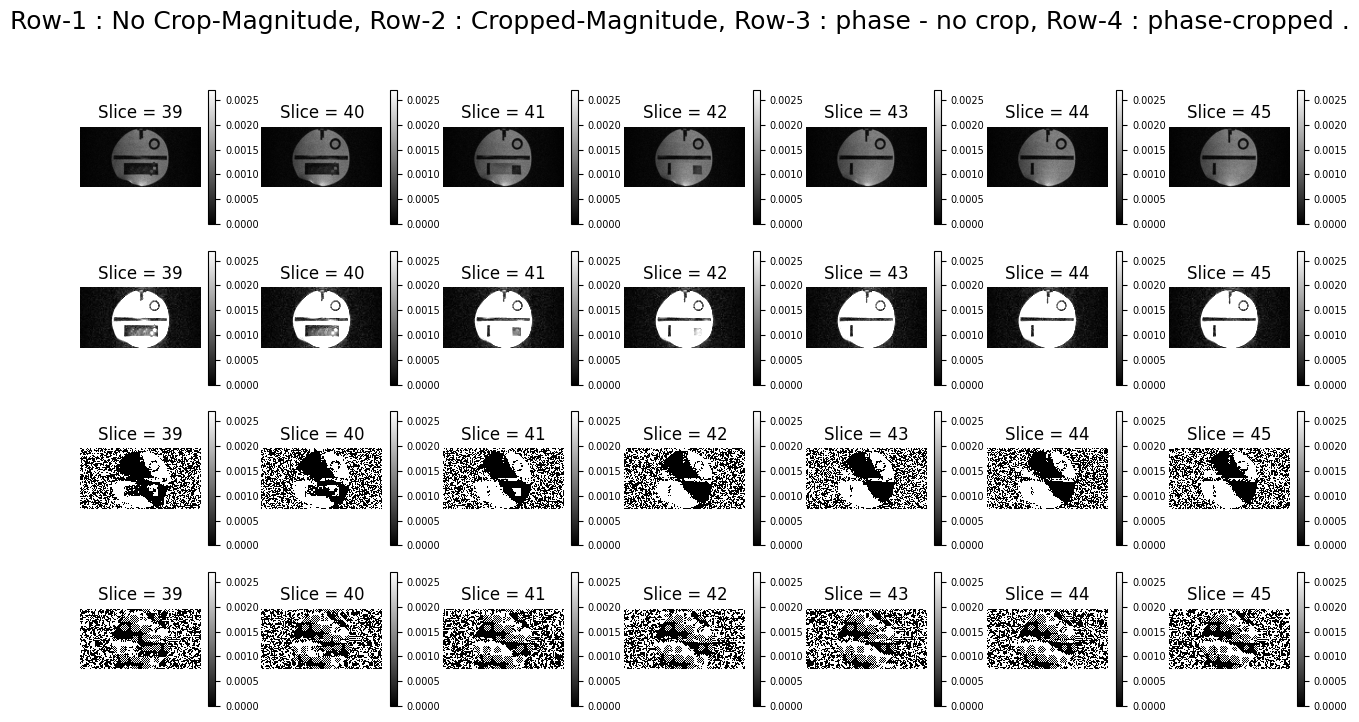

In [244]:
transform = v2.CenterCrop((55,110))
f_pos_2 = transform(f_pos)
img_pos_2 = torch.fft.ifftshift(torch.fft.ifftn(f_pos_2))
print(img_pos_2.shape,img_pos.shape)
slices = [39,40,41,42,43,44,45]
z1 = img_pos.reshape(100,img_pos.shape[-2],img_pos.shape[-1])
z2 = img_pos_2.reshape(100,img_pos_2.shape[-2],img_pos_2.shape[-1])
phase1 = (torch.atan2(torch.imag(z1),torch.real(z1)))
phase2 = (torch.atan2(torch.imag(z2),torch.real(z2)))
z = [z1.abs(),z2.abs(),phase1,phase2]
plt_images(slices,z,"Row-1 : No Crop-Magnitude, Row-2 : Cropped-Magnitude, Row-3 : phase - no crop, Row-4 : phase-cropped .",0, 0.0027)

In [230]:
img_pos_2.shape

torch.Size([100, 55, 110])

torch.Size([100, 55, 110])


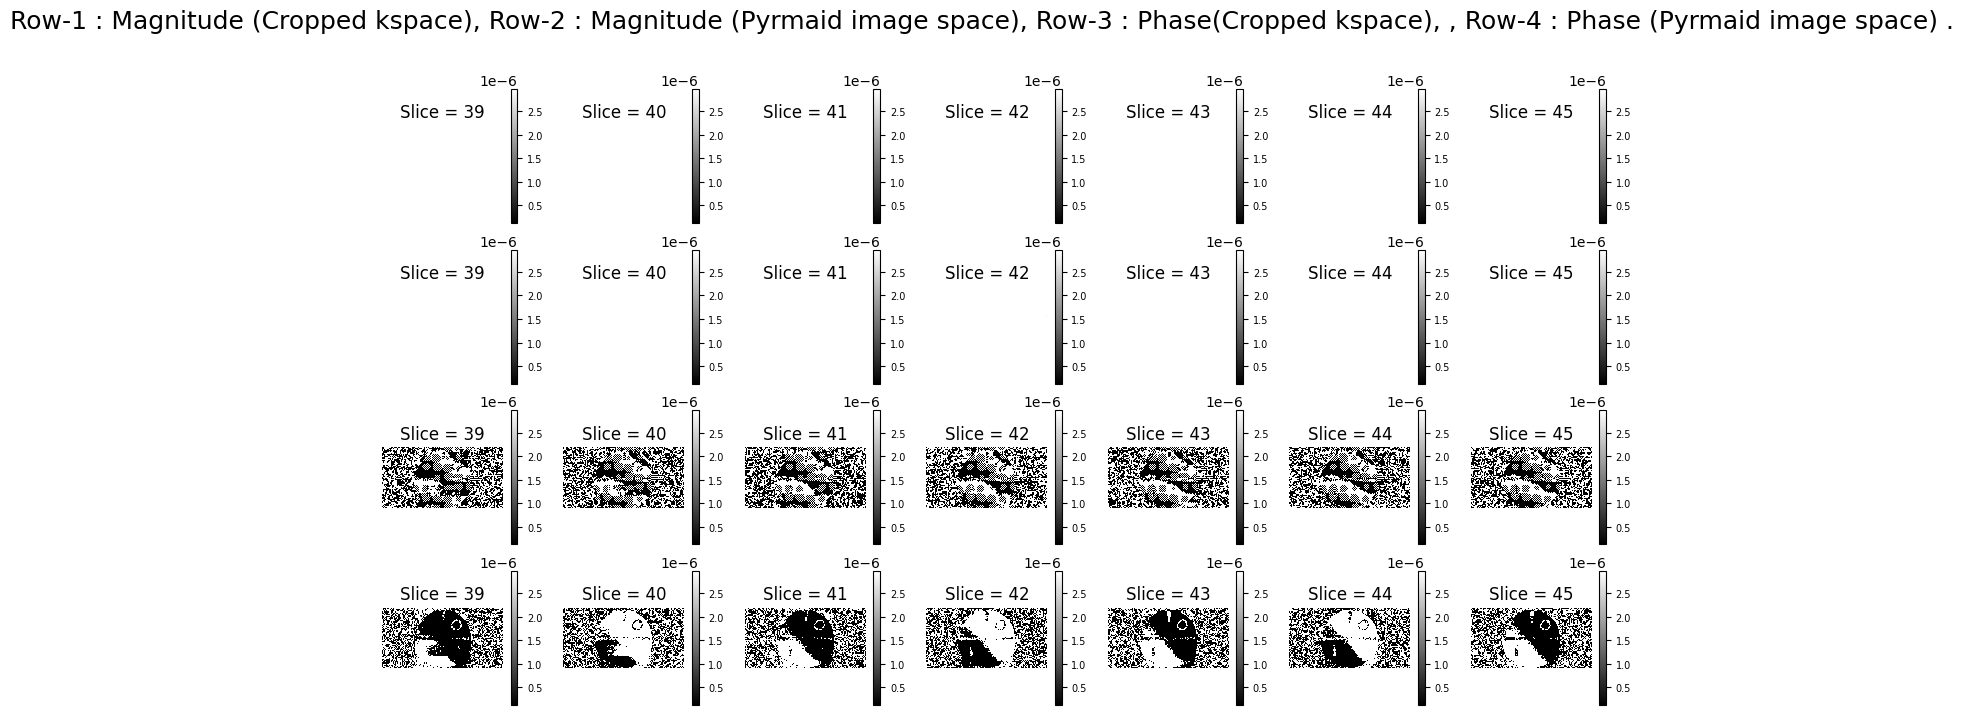

In [226]:
temp1 = complex_upsample(img_pos.reshape(1,100,110,220),size=(55,110))
# temp2 = complex_upsample(img_pos.reshape(1,100,110,220),size=(27,55))
slices = [39,40,41,42,43,44,45]
z1 = img_pos_2.reshape(100,img_pos_2.shape[-2],img_pos_2.shape[-1])
z2 = temp1.reshape(100,temp1.shape[-2],temp1.shape[-1])
print(z1.shape)
phase1 = torch.atan2(torch.imag(z1),torch.real(z1))
phase2 = torch.atan2(torch.imag(z2),torch.real(z2))
z = [z1.abs(),z2.abs(),phase1,phase2]
plt_images(slices,z,"Row-1 : Magnitude (Cropped kspace), Row-2 : Magnitude (Pyrmaid image space), Row-3 : Phase(Cropped kspace), , Row-4 : Phase (Pyrmaid image space) .",minmin, maxmax)

In [225]:
minmin = torch.min(torch.min(z1.abs(),z2.abs()))
maxmax = torch.min(torch.max(z1.abs(),z2.abs()))
print(minmin,maxmax)

tensor(1.2608e-07, dtype=torch.float64) tensor(2.9734e-06, dtype=torch.float64)


In [16]:
'''

from torchvision.transforms import v2
blurrer = v2.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2.0))

def gaussian_pyramid(img, n):
    img = img.reshape(1,img.shape[-3],img.shape[-2],img.shape[-1])
    print(img.shape)
    pyramid = []
    size_1= int(img.shape[-1])
    size_2 = int(img.shape[-2])

    
    # img = blurrer(img)
    # print(img.sum())
    img_real = Fun.interpolate(img.real, size = (size_2,size_1), mode='bicubic', align_corners=True)
    # print(img_real.sum())
    img_imag = Fun.interpolate(img.imag, size = (size_2,size_1), mode='bicubic', align_corners=True)
    # print(img_imag.sum())
    pyramid.append(torch.complex(img_real,img_imag))

    for i in range(1,n):
        size_1 = int(size_1/2)
        size_2 = int(size_2/2)
        img_real = Fun.interpolate(img.real, size = (size_2,size_1), mode='bicubic', align_corners=True)
        img_imag = Fun.interpolate(img.imag, size = (size_2,size_1), mode='bicubic', align_corners=True)
        img_complex = torch.complex(img_real,img_imag)
        pyramid.append(img_complex)
    return pyramid
'''

torch.Size([100, 27, 55])


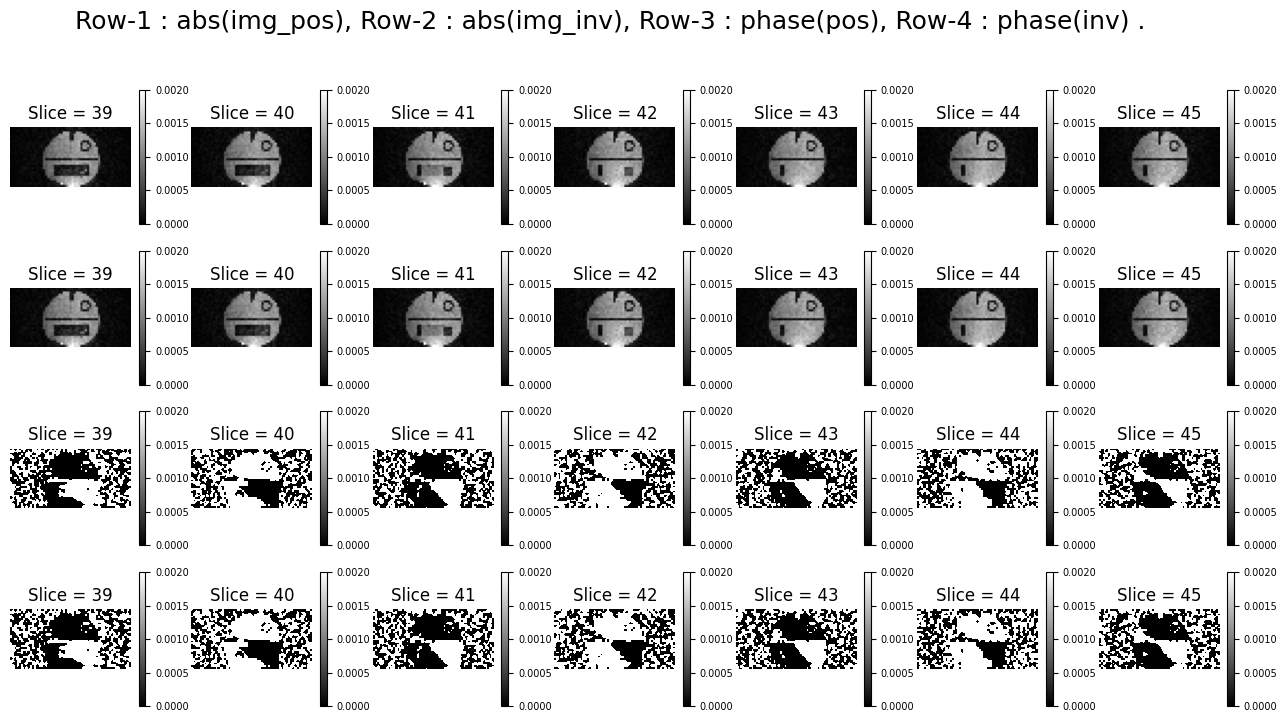

In [90]:
temp1 = complex_upsample(img_pos.reshape(1,100,110,220),size=(27,55))
temp2 = complex_upsample(img_pos.reshape(1,100,110,220),size=(27,55))
slices = [39,40,41,42,43,44,45]
z1 = temp1.reshape(100,temp1.shape[-2],temp1.shape[-1])
z2 = temp2.reshape(100,temp2.shape[-2],temp2.shape[-1])
print(z1.shape)
phase1 = torch.atan2(torch.imag(z1),torch.real(z1))
phase2 = torch.atan2(torch.imag(z2),torch.real(z2))
z = [z1.abs(),z2.abs(),phase1,phase2]
plt_images(slices,z,"Row-1 : abs(img_pos), Row-2 : abs(img_inv), Row-3 : phase(pos), Row-4 : phase(inv) .",0, 0.002)

In [127]:
from torchvision.transforms import v2
blurrer = v2.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2.0))

def complex_gaussian_pyramid(img, n):
    
    img = img.reshape(1,img.shape[-3],img.shape[-2],img.shape[-1])
    # print(img.shape)
    pyramid = []
    size_1= int(img.shape[-1])
    size_2 = int(img.shape[-2])

    
    # img = blurrer(img)
    # print(img.sum())
    # img_real = Fun.interpolate(img.real, size = (size_2,size_1), mode='bilinear',antialias=True)
    # print(img_real.sum())
    # img_imag = Fun.interpolate(img.imag, size = (size_2,size_1), mode='bilinear',antialias=True)
    # print(img_imag.sum())
    img0 = complex_upsample(img,size=(27,55))
    # pyramid.append(torch.complex(img_real,img_imag))
    pyramid.append(img0)

    for i in range(1,n):
        
        size_1 = int(size_1/2)
        size_2 = int(size_2/2)
        # img_real = Fun.interpolate(img.real, size = (size_2,size_1), mode='bilinear',antialias=True)
        # img_imag = Fun.interpolate(img.imag, size = (size_2,size_1), mode='bilinear',antialias=True)
        # img_complex = torch.complex(img_real,img_imag)
        # img_complex = img_real
        img_complex = complex_upsample(img,size = (size_2,size_1))
        pyramid.append(img_complex)
    return pyramid

3
torch.Size([100, 27, 55])


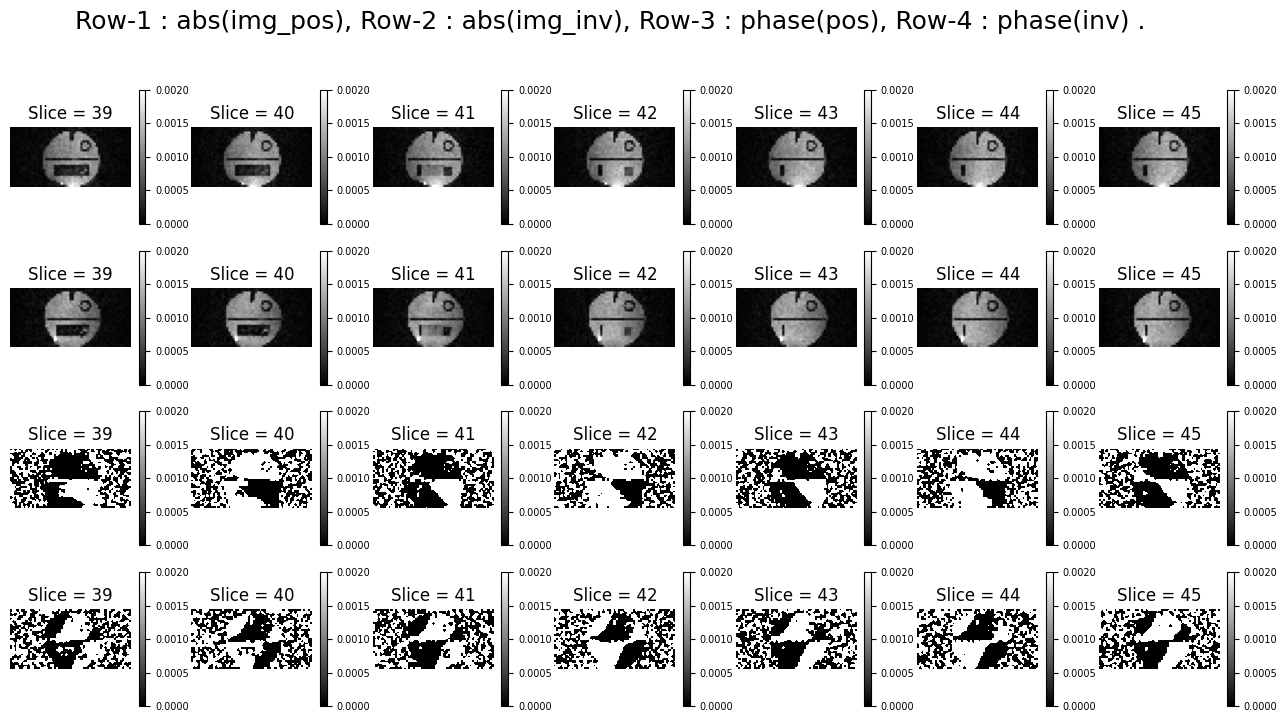

In [128]:
slices = [39,40,41,42,43,44,45]

img_pos_pyramid = complex_gaussian_pyramid(img_pos,3)
img_inv_pyramid = complex_gaussian_pyramid(img_inv,3)
print(len(img_pos_pyramid))
index = 2
z1 = img_pos_pyramid[index].reshape(100,img_pos_pyramid[index].shape[-2],img_pos_pyramid[index].shape[-1])
z2 = img_inv_pyramid[index].reshape(100,img_pos_pyramid[index].shape[-2],img_pos_pyramid[index].shape[-1])
print(z1.shape)
phase1 = torch.atan2(torch.imag(z1),torch.real(z1))
phase2 = torch.atan2(torch.imag(z2),torch.real(z2))
z = [z1.abs(),z2.abs(),phase1,phase2]
plt_images(slices,z,"Row-1 : abs(img_pos), Row-2 : abs(img_inv), Row-3 : phase(pos), Row-4 : phase(inv) .",0, 0.002)

kspace undersampling

In [ ]:
def resize_arrays(img,kspa, size: (int, int)):
        """ Resize arrays for image size changes (e.g. remove kspace lines etc.)

        Called by undersampling kspace and the image_change method. If the FOV
        is modified, image_change will reset the size based on the original
        kspace, performs other modifications to the image that are applied
        before undersampling and then reapplies the size change.

        Parameters:
            size (int, int): size of the new array
        """
        img.resize(size)
        # image_display_data.resize(size)
        # kspace_display_data.resize(size)
        # kspace_abs.resize(size)
        kspacedata.resize(size, refcheck=False)

In [144]:
def undersample(kspace, factor, compress):
        """ Skipping every nth kspace line

        Simulates acquiring every nth (where n is the acceleration factor) line
        of kspace, starting from the midline. Commonly used in SENSE algorithm.

        Parameters:
            kspace: Complex k-space numpy.ndarray
            factor: Only scan every nth line (n=factor) starting from midline
            compress: compress kspace by removing empty lines (rectangular FOV)
        """
        # TODO memory optimise this (kspace sized memory created 3 times)
        if factor > 1:
            mask = np.ones(kspace.shape, dtype=bool)
            
            midline = kspace.shape[0] // 2
            mask[midline::factor] = 0
            mask[midline::-factor] = 0
            if compress:
                q = kspace[~mask]
                q = q.reshape(q.size // kspace.shape[1], kspace.shape[1])
                print(q.shape)
                # im.resize_arrays(q.shape)
                kspace.resize(q.size)
                kspace[:] = q[:]
            else:
                kspace[mask] = 0

In [167]:
def undersample(t):
    
    # t = torch.randn(100,110,220)
    width_list = (range(0,t.shape[-1]))
    height_list = (range(0,t.shape[-2]))
    width_list = [a for a in width_list if a % 2 == 0]
    height_list = [a for a in height_list if a % 2 == 0]

    #Slicing every alternate row
    t = t[:,:, width_list]
    t = t[:,height_list,:]
    return t
    # print(t.shape)

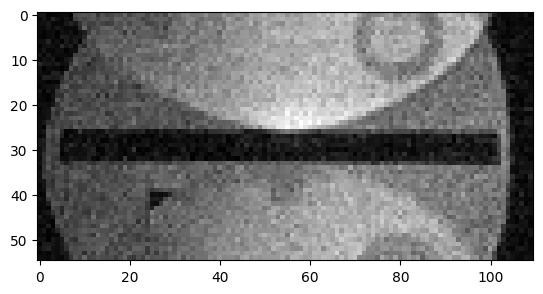

In [188]:
t1 = torch.fft.ifftshift(torch.fft.ifftn(undersample(f_pos))).abs()
plt.imshow(t1[50],cmap='gray')

In [160]:
t = torch.tensor([[ 1, 2, 3, 4, 5], [ 6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
print(t[:, [0, 2, 4]])


tensor([[ 1,  3,  5],
        [ 6,  8, 10],
        [11, 13, 15]])


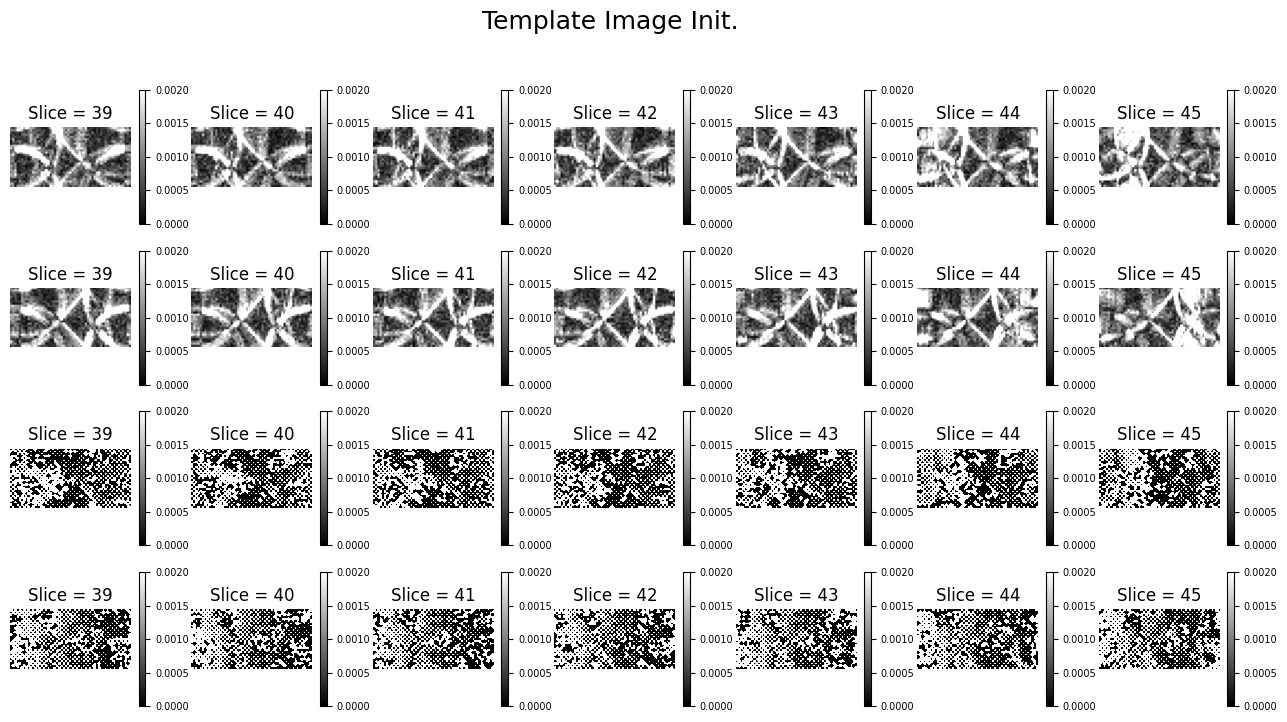

In [176]:
slices = [39,40,41,42,43,44,45]

# img_pos_pyramid = [torch.fft.ifftn(gaussian_pyramid(f_pos,3)) for i in range(3)]
# img_inv_pyramid = [torch.fft.ifftn(gaussian_pyramid(f_inv,3)) for i in range(3)]

img_pos_pyramid = complex_gaussian_pyramid(f_pos,3)
img_inv_pyramid = complex_gaussian_pyramid(f_inv,3)


# img_inv_pyramid = torch.fft.ifftn(gaussian_pyramid(f_inv,3))
index = 0
z1 = img_pos_pyramid[index].reshape(100,img_pos_pyramid[index].shape[-2],img_pos_pyramid[index].shape[-1])
z1 = torch.fft.ifftn(z1)
z2 = img_inv_pyramid[index].reshape(100,img_pos_pyramid[index].shape[-2],img_pos_pyramid[index].shape[-1])
z2 = torch.fft.ifftn(z2)
phase1 = torch.atan2(torch.imag(z1),torch.real(z1))
phase2 = torch.atan2(torch.imag(z2),torch.real(z2))
z = [z1.abs(),z2.abs(),phase1,phase2]
plt_images(slices,z,"Template Image Init.",0, 0.002)

In [261]:
print(img_pos_pyramid[0].shape, img_pos_pyramid[1].shape)

torch.Size([1, 100, 220, 110]) torch.Size([1, 100, 110, 55])


In [ ]:

f_pos_pyramid = complex_pyramid(f_pos.reshape(1,f_pos.shape[-3],f_pos.shape[-2],f_pos.shape[-1]))
f_inv_pyramid = complex_pyramid(f_inv.reshape(1,f_pos.shape[-3],f_pos.shape[-2],f_pos.shape[-1]))

z1 = img_pos_pyramid[-3].reshape(100,55,110)
z2 = img_inv_pyramid[-3].reshape(100,55,110)
z4 = torch.abs(torch.fft.ifftn(f_pos_pyramid[-3])).reshape(100,55,110)
z5 = torch.abs(torch.fft.ifftn(f_inv_pyramid[-3])).reshape(100,55,110)

In [13]:

w = torch.Field.identity(1,2,13,27,requires_grad=True)

template_image_list = []
w_list = []
losses = []

/var/folders/jn/htj79lg12cg80r08kmc0y55h00z9nl/T/ipykernel_29401/28451812.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  template_img = torch.tensor((img_pos_pyramid[-1]+img_inv_pyramid[-1])/2,requires_grad=True)
/var/folders/jn/htj79lg12cg80r08kmc0y55h00z9nl/T/ipykernel_29401/28451812.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  avg2 = torch.tensor((img_pos_pyramid[0]+img_inv_pyramid[0])/2)


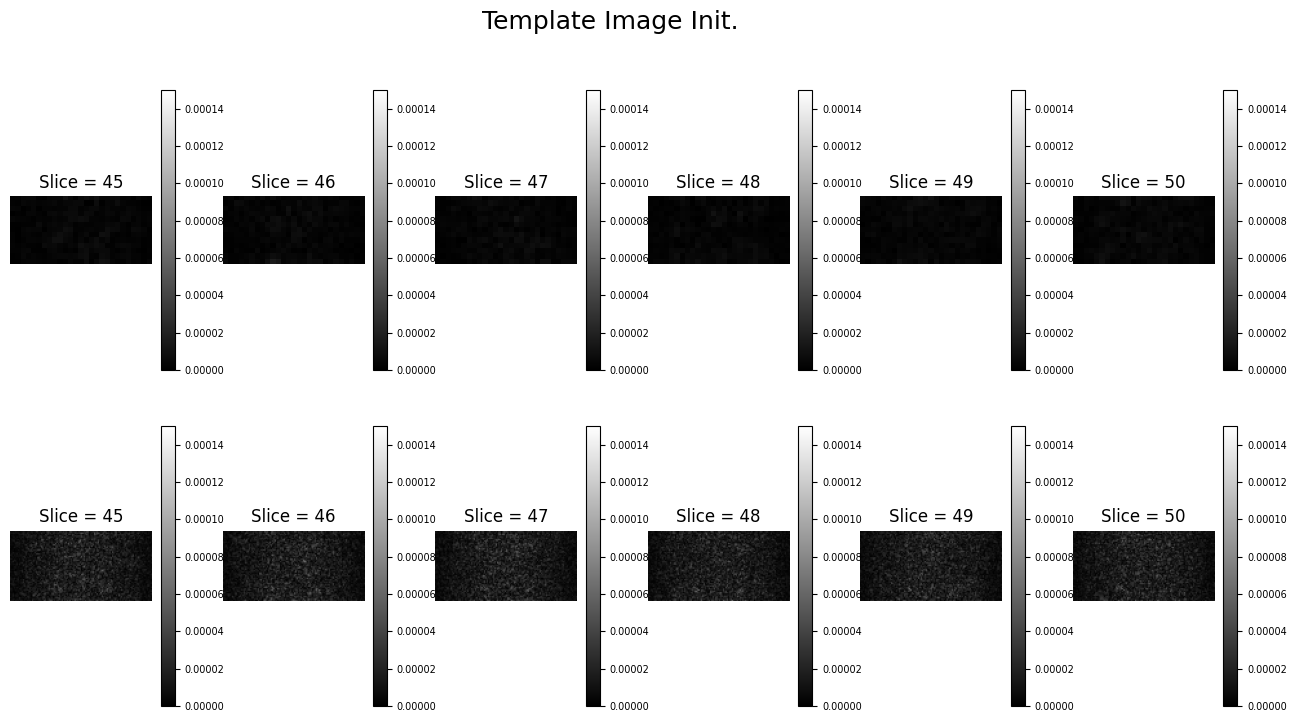

In [34]:

#Template Image Initialization
template_img = torch.tensor((img_pos_pyramid[-1]+img_inv_pyramid[-1])/2,requires_grad=True)
# template_img = blurrer(template_img)
w = torch.Field.identity(1,2,13,27,requires_grad=True)
avg = template_img.clone().detach()
avg = avg.reshape(img_pos.shape[-3],avg.shape[-2],avg.shape[-1])


avg2 = torch.tensor((img_pos_pyramid[0]+img_inv_pyramid[0])/2)
avg2 = avg2.reshape(avg.shape[-3],avg2.shape[-2],avg2.shape[-1])
# print(avg.shape)


slices = [45,46,47,48,49,50]
z = [avg.abs(),((img_pos_pyramid[-3]+img_inv_pyramid[-3])/2).abs().reshape(100,55,110)]
plt_images(slices,z,"Template Image Init.",0, 0.00015)

In [27]:
print(img_pos_pyramid[-1].shape,img_pos_pyramid[-2].shape,img_pos_pyramid[-3].shape,img_pos_pyramid[-4].shape)

torch.Size([1, 100, 13, 27]) torch.Size([1, 100, 27, 55]) torch.Size([1, 100, 55, 110]) torch.Size([1, 100, 110, 220])


torch.Size([1, 100, 110, 220])


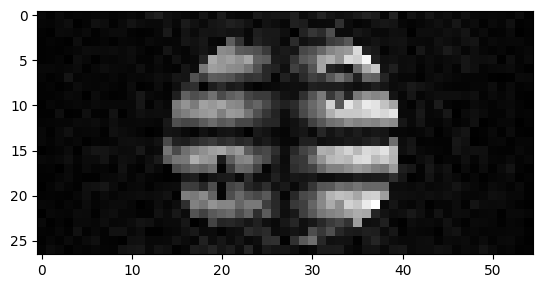

In [233]:
from torchvision.transforms import v2
blurrer = v2.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2.0))
B = blurrer(img_pos)
print(B.shape)
B = img_pos.reshape(1,100,110, 220)
b_usample_real = Fun.interpolate(B.real, size = (110,220), mode='bicubic', align_corners=True)
b_usample_imag = Fun.interpolate(B.imag, size = (110,220), mode='bicubic', align_corners=True)
z5 = torch.complex(b_usample_real,b_usample_imag)
plt.imshow(z5.abs()[0,45,], cmap='gray')

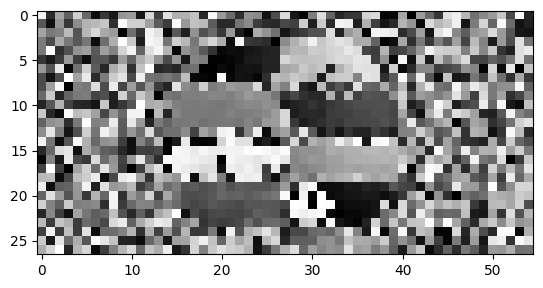

In [230]:
phase1 = torch.atan2(torch.imag(z5),torch.real(z5))
plt.imshow(phase1[0,45,], cmap='gray')

In [329]:
B.shape

torch.Size([1, 100, 110, 220])